In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_pickle('data_Han/Han_df_cleaned')

In [3]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,2,6,770,0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,2,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.view.value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

# ASSUMPTIONS

 ***LIVING SPACE*** 
 * bigger house sells more?
 * more bedrooms/bathrooms sells more?
 * more floors sells more?
 * space allocations
 * Floor Area Ratio sells more?
 
 
 ***LOCATION***
 * waterfront/view important?
 * neiborhood important?
 * zipcode / which area is hot? hot because of what?
 * is height important?/flood
 
 
 ***INVESTMENT***
 * year built
 * view/waterfront
 * flood zone/latitude
 
 
 ***OVERALL INTUITION***
 * sqrt_living
 * bedrooms/bathrooms
 * view/waterfront
 * zipcode
 * year_built

# LIVING SPACE

### get needed columns

In [5]:
col_selector = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_basement']
df_ls = df[col_selector]

### Create new columns by combining

In [6]:
# FAR
df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']

<ipython-input-6-54d9d6b413a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['FAR'] = df_ls['sqft_living'] / df_ls['sqft_lot']


In [7]:
df_ls.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,FAR
0,221900.0,3,1.00,1180,5650,1.0,0,0.208850
1,538000.0,3,2.25,2570,7242,2.0,400,0.354874
2,180000.0,2,1.00,770,10000,1.0,0,0.077000
3,604000.0,4,3.00,1960,5000,1.0,910,0.392000
4,510000.0,3,2.00,1680,8080,1.0,0,0.207921


In [8]:
# Living space / bedrooms
# higher means you have more space for other rooms
# such as kitchen, living room, game room, home gym
df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']

<ipython-input-8-17e96cc7dcf6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ls['Living_Space_VS_Bedroom'] = (df_ls['sqft_living'] - df_ls['sqft_basement'])/df_ls['bedrooms']


### basic check

In [9]:
df_ls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    21597 non-null  float64
 1   bedrooms                 21597 non-null  int64  
 2   bathrooms                21597 non-null  float64
 3   sqft_living              21597 non-null  int64  
 4   sqft_lot                 21597 non-null  int64  
 5   floors                   21597 non-null  float64
 6   sqft_basement            21597 non-null  int32  
 7   FAR                      21597 non-null  float64
 8   Living_Space_VS_Bedroom  21597 non-null  float64
dtypes: float64(5), int32(1), int64(3)
memory usage: 1.4 MB


In [10]:
df_ls.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,FAR,Living_Space_VS_Bedroom
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.371811,2.115826,2080.321850,1.509941e+04,1.494096,285.716581,0.323755,537.372969
std,3.673681e+05,0.904096,0.768984,918.106125,4.141264e+04,0.539683,439.819830,0.268460,205.204983
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000610,145.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.156663,390.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.247666,496.666667
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,550.000000,0.407609,640.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,4820.000000,4.653846,3000.000000


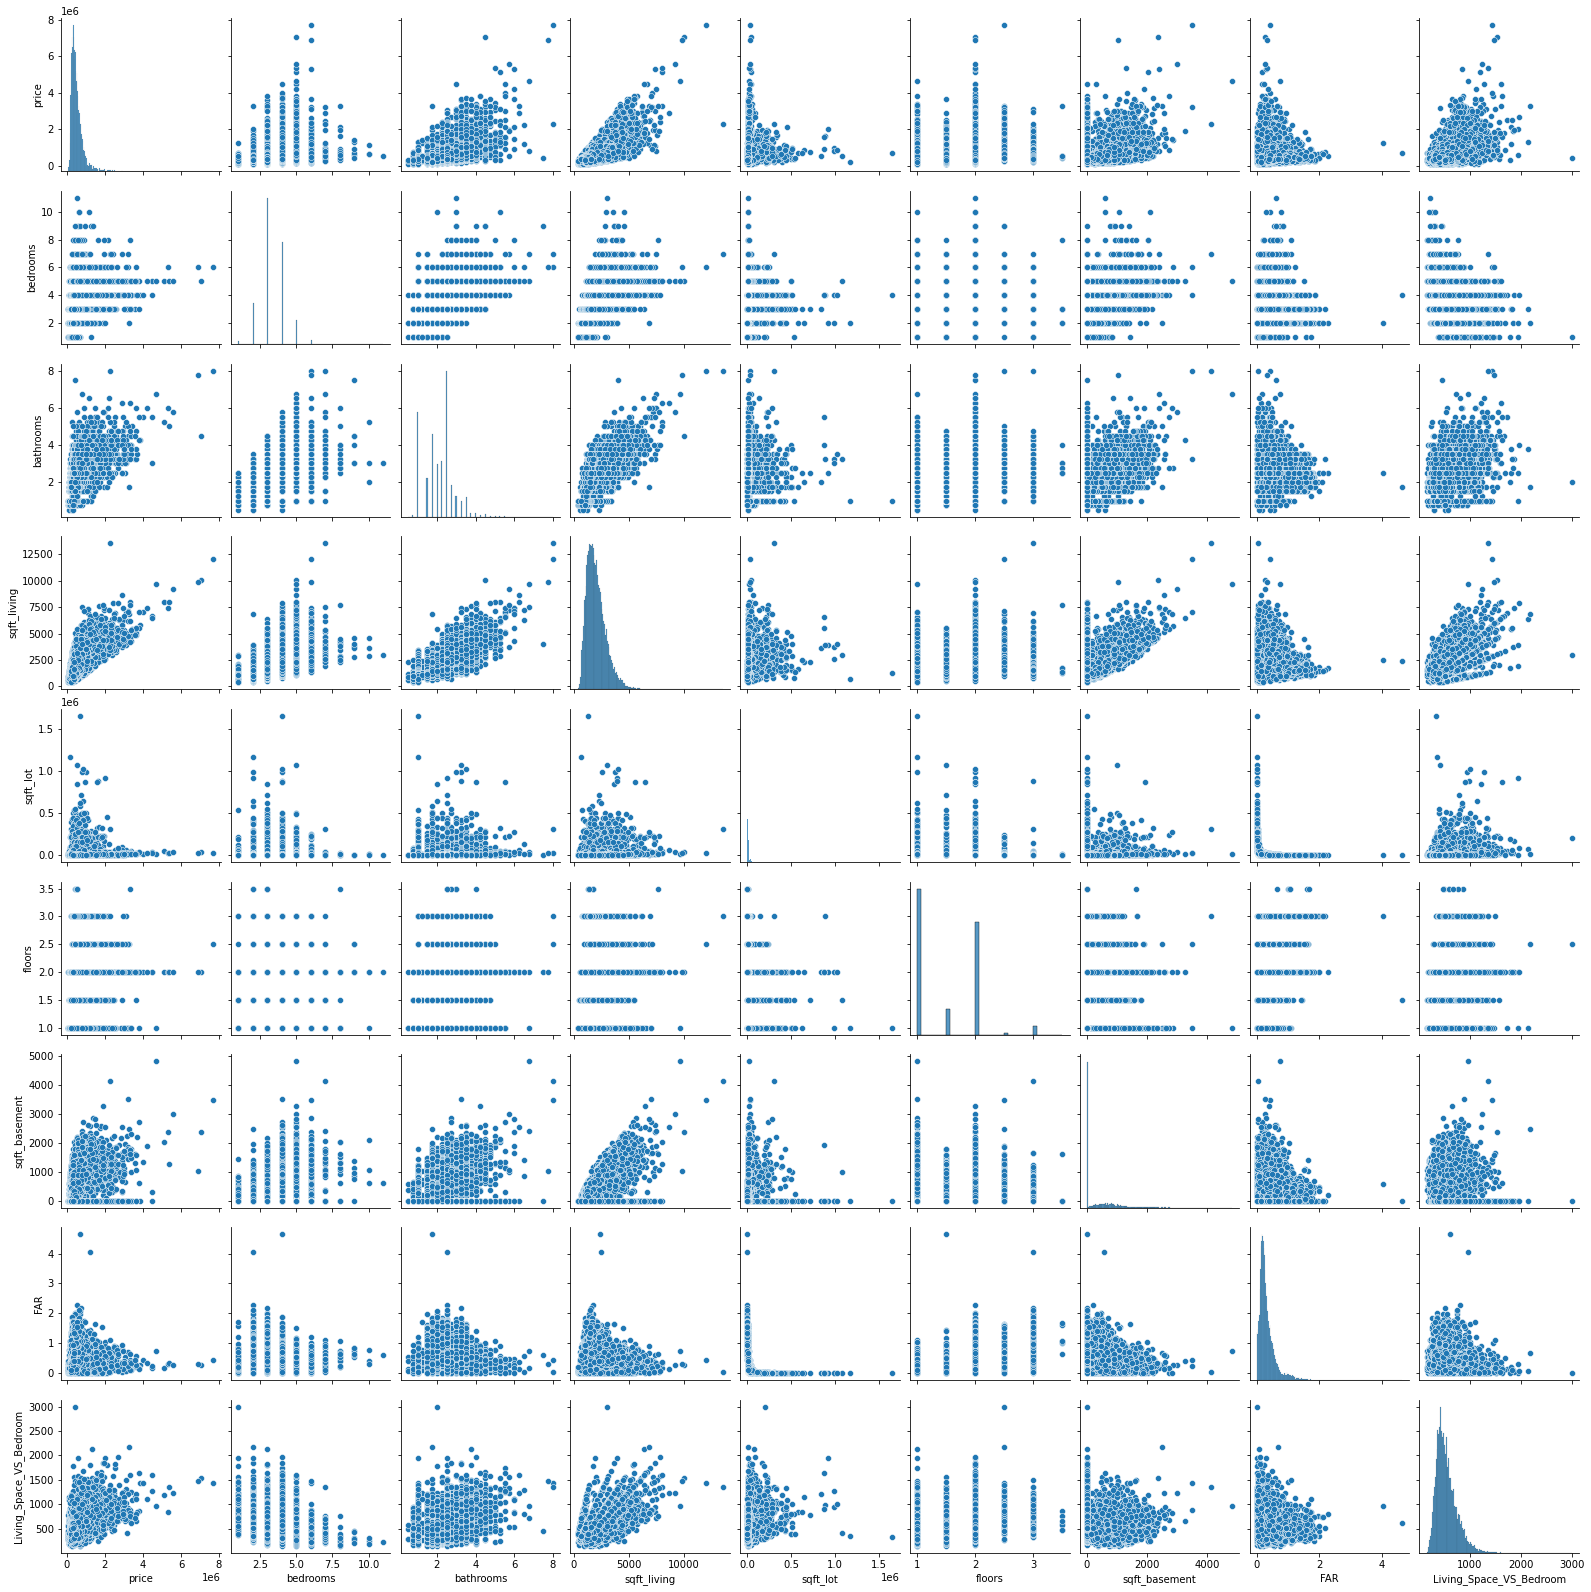

In [11]:
sns.pairplot(df_ls)

<AxesSubplot:>

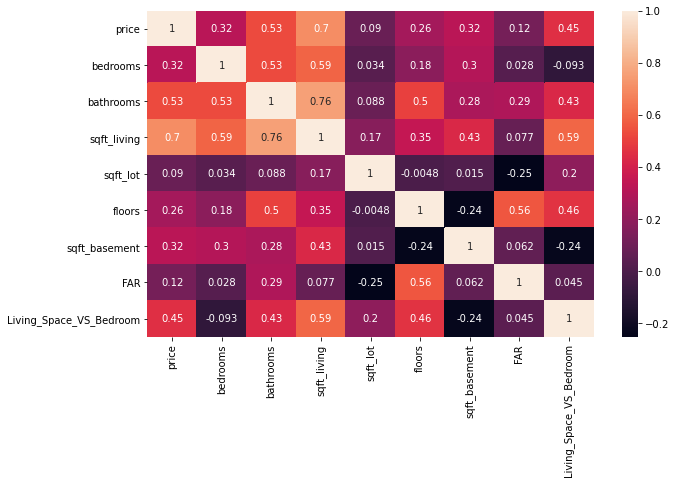

In [12]:
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_ls.corr(),annot = True,ax=ax)

***outstanding***
* sqft_living vs price
* sqft_living vs bathrooms/bedrooms
* bathroom corelates more with price
* living_space_VS_Bedrooms vs sqft_living


### check out FAR vs sqrt_lot

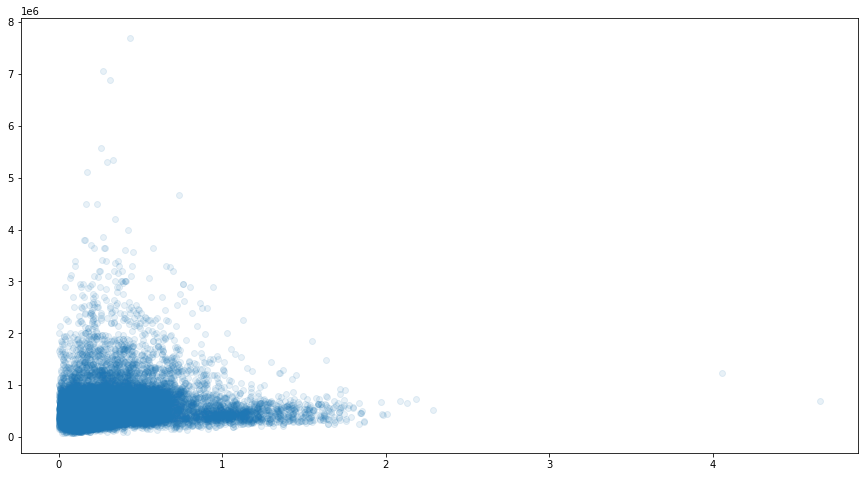

In [13]:
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(df_ls.FAR,df_ls.price,alpha=0.1)

In [14]:
# can't tell too much now

# living space simple baseline model

In [15]:
col_selector = ['sqft_living','bedrooms','Living_Space_VS_Bedroom','sqft_lot', 'floors']
X_ls = df_ls[col_selector]
y = df_ls.price

In [16]:
X_ls_stand = X_ls.apply(lambda x: (x-x.mean()/x.std()))
y_stand = (y-y.mean())/y.std()

In [17]:
ls_simple_model = sm.OLS(y_stand,sm.add_constant(X_ls_stand)).fit()

In [18]:
print(ls_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     4562.
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:36:16   Log-Likelihood:                -22858.
No. Observations:               21597   AIC:                         4.573e+04
Df Residuals:                   21591   BIC:                         4.578e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# LOCATION

In [21]:
col_selector = ['zipcode','view','waterfront','grade','yr_built']
df_loc = df[col_selector]

In [22]:
df_loc.head()

,zipcode,view,waterfront,grade,yr_built
0,98178,0,0,7,1955
1,98125,0,0,7,1951
2,98028,0,0,6,1933
3,98136,0,0,7,1965
4,98074,0,0,8,1987


tips from other sources


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

https://towardsdatascience.com/predicting-house-prices-with-linear-regression-machine-learning-from-scratch-part-ii-47a0238aeac1

https://www.bryanshalloway.com/2020/08/17/pricing-insights-from-historical-data-part-1/